### Import required packages

In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from prettytable import PrettyTable  # To print in tabular format

from sklearn.metrics import confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, roc_curve, accuracy_score, auc, confusion_matrix
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns

from sklearn import linear_model, neighbors, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

import pickle

sns.set_style("whitegrid")

### Helper functions

In [2]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # roc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = clf.score(x_train, y_train)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = clf.score(x_test, y_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'Recall', 'Percision','False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_recall, train_precision, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1,test_recall, test_precision, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far, test_recall, test_precision

### Prepare our models for ensembling

In [11]:
X = pd.read_csv('data/pre-processed-x_train-data.csv')
y = pd.read_csv('data/pre-processed-y_train-data.csv')
df = X.join(y)
train= df.copy(deep=True)


In [12]:
del df, X, y
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
del train

In [13]:
X_train, X_test, y_train, X_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Define models with proper parameters

In [15]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=29, n_jobs=-1)
lr_model = LogisticRegression(C=100, solver='newton-cg')
dt_model = DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=4,
                       min_impurity_decrease=0, min_weight_fraction_leaf=0)
rf_model = RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                       min_samples_split=12)
et_model = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=1)
models = ["lr_model", "knn_model", "rf_model", "et_model"]

### Fit and save the models in pickle format

In [37]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"models/{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

### Experimenting on ensembeling models

In [6]:
df= pd.read_csv("data/data_for_validation.csv")
df=df.iloc[:,1:]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), 
                                                    df.label, 
                                                    random_state=42
                                                   )

### Load pre-trained/tuned models

In [12]:
model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"model/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [13]:
model_list

[('lr_model', LogisticRegression(C=100, random_state=1, solver='liblinear')),
 ('knn_model',
  KNeighborsClassifier(metric='manhattan', n_neighbors=26, weights='distance')),
 ('rf_model', RandomForestClassifier(random_state=1)),
 ('et_model', ExtraTreesClassifier(random_state=1))]

In [14]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.9379562043795621
knn_model score: 0.9854014598540146
rf_model score: 0.9863138686131386
et_model score: 0.9869981751824818


### Trying: VotingClassifier(hard)

+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
| Dataset |          Model          |        AUC         |      F1-score      |       Recall       |     Percision      |    False Alarm Rate   |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
|  Train  | Voting Classifier(hard) | 0.9990114068441065 | 0.9992733776759265 | 0.9987709497206704 | 0.9997763113745666 | 0.0008526203777600425 |
|   Test  | Voting Classifier(hard) | 0.9500456204379562 | 0.9641864268192968 | 0.9758358159549818 | 0.9528118939883645 |  0.06564041924187815  |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+


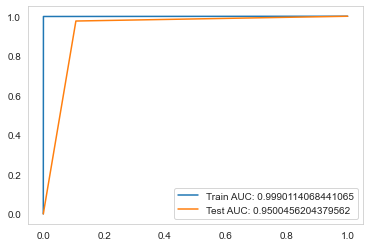

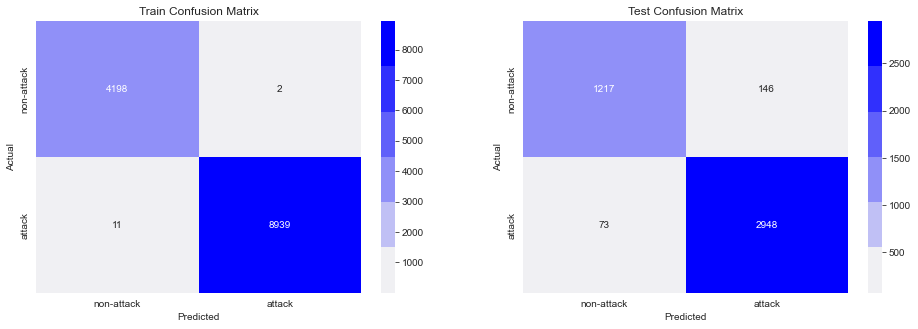

(VotingClassifier(estimators=[('lr_model',
                               LogisticRegression(C=100, random_state=1,
                                                  solver='liblinear')),
                              ('knn_model',
                               KNeighborsClassifier(metric='manhattan',
                                                    n_neighbors=26,
                                                    weights='distance')),
                              ('rf_model',
                               RandomForestClassifier(random_state=1)),
                              ('et_model',
                               ExtraTreesClassifier(random_state=1))],
                  n_jobs=-1),
 0.9500456204379562,
 0.9641864268192968,
 0.06564041924187815,
 0.9758358159549818,
 0.9528118939883645)

In [25]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
evaluate_result(voting_classifer,X_train,y_train,X_test, y_test,"Voting Classifier(hard)")

### Trying: VotingClassifier(soft)

+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
| Dataset |          Model          |        AUC         |      F1-score      |       Recall       |     Percision      |   False Alarm Rate   |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|  Train  | Voting Classifier(soft) | 0.9990114068441065 | 0.9992741890458379 | 0.9998882681564246 | 0.9986608637428859 | 0.001484437350359138 |
|   Test  | Voting Classifier(soft) | 0.948905109489051  | 0.963718820861678  | 0.9847732538894406 | 0.943545829368855  |  0.0729105117199899  |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+


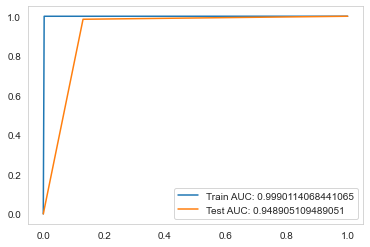

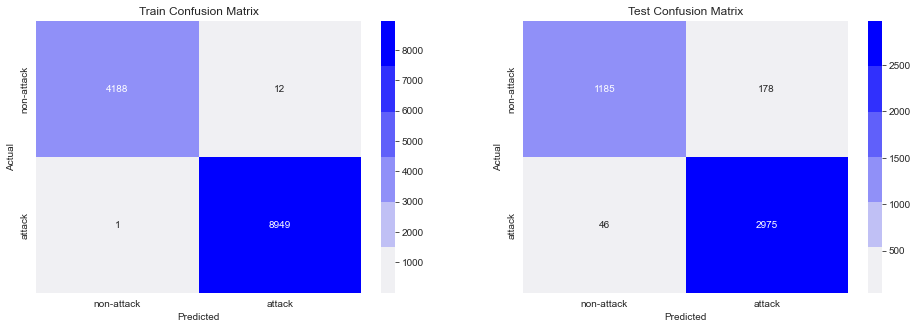

(VotingClassifier(estimators=[('lr_model',
                               LogisticRegression(C=100, random_state=1,
                                                  solver='liblinear')),
                              ('knn_model',
                               KNeighborsClassifier(metric='manhattan',
                                                    n_neighbors=26,
                                                    weights='distance')),
                              ('rf_model',
                               RandomForestClassifier(random_state=1)),
                              ('et_model',
                               ExtraTreesClassifier(random_state=1))],
                  n_jobs=-1, voting='soft'),
 0.948905109489051,
 0.963718820861678,
 0.0729105117199899,
 0.9847732538894406,
 0.943545829368855)

In [27]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)
evaluate_result(voting_classifer, X_train, y_train, X_test, y_test, "Voting Classifier(soft)")

In [27]:
# tring weight
# create voting classifier
weights = [1,1,2.2,4.2]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,  #include weights
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=100, random_state=1,
                                                 solver='liblinear')),
                             ('knn_model',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=26,
                                                   weights='distance')),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2.2, 4.2])

In [28]:
# Get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_model.predict(X_test)
# accuracy_score(y_test, y_pred)
print("The score for voting classifier is")
print("Training: {:6.2f}%".format(100*voting_model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*voting_model.score(X_test, y_test)))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
print('F1 : {:6.4f}'.format(f1_score(y_test, y_predict)))

0.9441149635036497

### Trying: StackingClassifier

+---------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
| Dataset |        Model        |        AUC         |      F1-score      |       Recall       |     Percision      |    False Alarm Rate   |
+---------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
|  Train  | Stacking Classifier | 0.9990114068441065 | 0.9992733776759265 | 0.9987709497206704 | 0.9997763113745666 | 0.0008526203777600425 |
|   Test  | Stacking Classifier | 0.9502737226277372 | 0.9644139732288607 | 0.9778219132737505 | 0.9513687600644123 |  0.06648155987082839  |
+---------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+


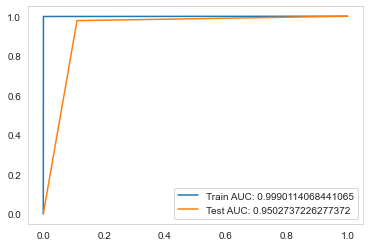

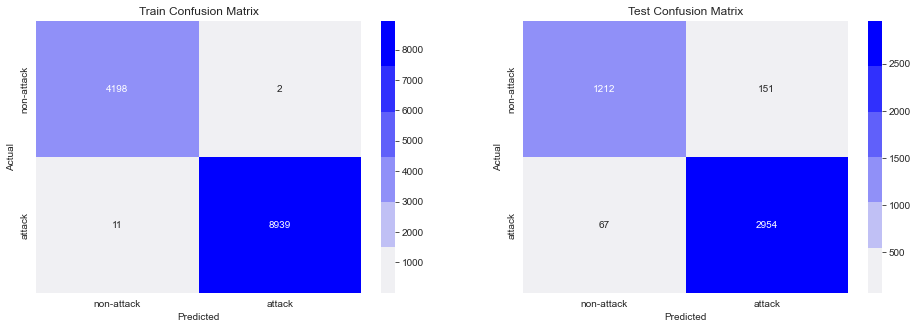

(StackingClassifier(classifiers=[LogisticRegression(C=100, random_state=1,
                                                    solver='liblinear'),
                                 KNeighborsClassifier(metric='manhattan',
                                                      n_neighbors=26,
                                                      weights='distance'),
                                 RandomForestClassifier(random_state=1),
                                 ExtraTreesClassifier(random_state=1)],
                    meta_classifier=LogisticRegression()),
 0.9502737226277372,
 0.9644139732288607,
 0.06648155987082839,
 0.9778219132737505,
 0.9513687600644123)

In [20]:
stacked = StackingClassifier(
    classifiers=model_vars,
    meta_classifier=LogisticRegression(),
    use_probas=False
)
evaluate_result(stacked, X_train, y_train, X_test, y_test, "Stacking Classifier")

## After experimenting the previous models we decided to go with the VotingClassifier(hard)
### we think it is the best to train/test the whole dataset

In [6]:
X = pd.read_csv('data/pre-processed-x_train-data.csv')
y = pd.read_csv('data/pre-processed-y_train-data.csv')
df = X.join(y)
train= df.copy(deep=True)


In [7]:
del df, X, y
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
del train

In [11]:
X_test

15482     0
133349    1
80485     1
29972     0
18339     0
         ..
117166    1
127121    1
16355     0
169100    1
170784    1
Name: label, Length: 43836, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [17]:
model_list

[('lr_model', LogisticRegression(C=100, solver='newton-cg')),
 ('knn_model', KNeighborsClassifier(n_jobs=-1, n_neighbors=29)),
 ('rf_model',
  RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=5,
                         min_samples_split=12)),
 ('et_model', ExtraTreesClassifier(random_state=1))]

In [18]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.9341637010676157
knn_model score: 0.9373574231225477
rf_model score: 0.9410530157861119
et_model score: 0.9536910302034857


+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
| Dataset |          Model          |        AUC         |      F1-score      |       Recall       |     Percision      |   False Alarm Rate  |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+
|  Train  | Voting Classifier(hard) | 0.9559408387513783 | 0.9685317343934998 | 0.9965130314274219 | 0.9420789045495848 | 0.06696035834943594 |
|   Test  | Voting Classifier(hard) | 0.9431289351218177 | 0.9596321064818564 | 0.9921982253473967 | 0.9291358334378528 | 0.08478271396720069 |
+---------+-------------------------+--------------------+--------------------+--------------------+--------------------+---------------------+


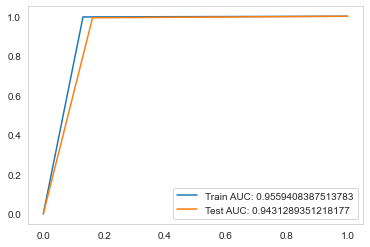

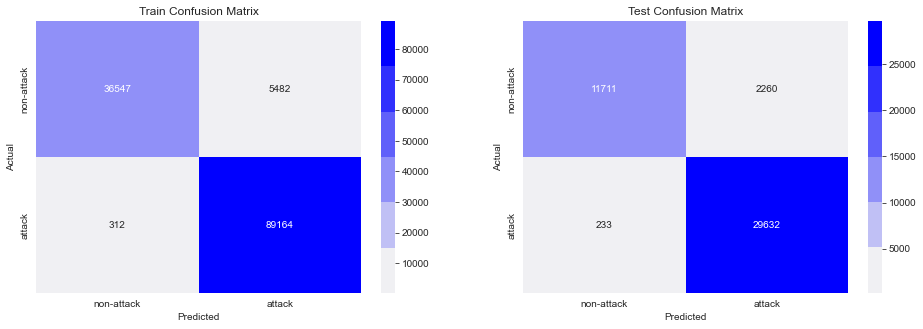

(VotingClassifier(estimators=[('lr_model',
                               LogisticRegression(C=100, solver='newton-cg')),
                              ('knn_model',
                               KNeighborsClassifier(n_jobs=-1, n_neighbors=29)),
                              ('rf_model',
                               RandomForestClassifier(max_depth=90,
                                                      max_features=2,
                                                      min_samples_leaf=5,
                                                      min_samples_split=12)),
                              ('et_model',
                               ExtraTreesClassifier(random_state=1))],
                  n_jobs=-1),
 0.9431289351218177,
 0.9596321064818564,
 0.08478271396720069,
 0.9921982253473967,
 0.9291358334378528)

In [19]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
evaluate_result(voting_classifer,X_train,y_train,X_test, y_test,"Voting Classifier(hard)")